<a href="https://colab.research.google.com/github/hyeonji826/AI/blob/main/AI%20Agent/5_LangGraph_Reflection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Reflection
Reflection은 에이전트가 스스로 결과를 평가·비판 한 뒤 그 피드백을 상태(state)에 기록하고, 필요하면 수정 루프로 되돌아가 답을 개선하는 설계 패턴입니다. 보통 “작성 노드(답 생성) → 리플렉션 노드(자기평가) → 라우팅(조건부 엣지)”로 구성되며, 리플렉션 노드는 품질 기준(예: 정확성, 근거, 형식)을 점수·코멘트(score, critique)로 남깁니다. 라우터는 이 정보를 읽어 임계값 미달이면 작성 노드로 되감기, 충족하면 종료 노드로 이동합니다. 무한 루프를 막기 위해 max_iters 같은 반복 한도를 두며, 툴 호출과는 별개로 LLM의 자기검토 능력을 활용해 코드 생성, 질의응답, 체인드 리저닝 등의 정확도·일관성을 높이는 데 쓰입니다.

<img src="https://blog.kakaocdn.net/dna/b1Ic0g/btsQwHJRkMb/AAAAAAAAAAAAAAAAAAAAAGKNg2obE4vZt0Q9Owo95bbskLQjFYuGpmMZ7DIAuDnX/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=Rnehl5D3y2D35AdwwyRmWFn%2B1%2Fw%3D" width=700>

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [ ]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.75
    Uninstalling langchain-core-0.3.75:
      Successfully uninstalled langchain-core-0.3.75


### 1. 가사 생성

In [ ]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "당신은 5단락 노래가사를 훌륭하게 작성하는 작사 도우미입니다."
            "사용자의 요청에 따라 최고의 가사를 작성하세요."
            "사용자가 피드백을 제공할 경우, 이전 시도에서 개선된 수정본을 작성해 응답하세요.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOpenAI(model="gpt-5-nano")
generate = prompt | llm

In [ ]:
lyric = ""
request = HumanMessage(
    content="코딩에 대한 가사를 작성해주세요."
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    lyric += chunk.content

검은 화면 위로 번쩍이는 숫자의 노래가 흐른다
커서가 깜빡일 때마다 세상은 다시 깨어난다
커피 향과 전기의 냄새 속에서 나는 코드를 노래한다
루프의 박자에 마음이 따라 흘러간다
새로운 시작은 늘 한 줄의 코드에서 시작된다

에러는 그림자, 디버거는 빛
컴파일은 숨을 고르는 순간
스택 트레이스가 길을 가리켜도 나는 포기하지 않는다
원인을 찾아 한 줄씩 고쳐나가며 배우는 법
브레이크포인트에 멈춰 선 마음은 다시 달려간다

함수는 마음의 문을 열고 닫는 열쇠
나는 이름 있는 인자들을 불러 모아 이야기를 만든다
반환값은 어제와 오늘 사이의 약속
조건문은 선택의 갈림길처럼 방향을 바꾼다
참과 거짓 사이에서 나는 최적의 길을 찾아 간다

깃은 협업의 지도, 커밋은 기억의 조각
브랜치는 서로 다른 꿈의 가지
병합은 충돌을 노래로 녹여 하나로 만든다
푸시와 풀은 서로의 이야기를 세계로 흘려보낸다
배포의 순간, 세상에 작은 기적이 모습을 드러낸다

다음 버전의 창밖에서 새로운 문제를 기다린다
계속 업데이트되며 배우는 나는 더 나아진다
오류를 친구 삼아도 성장하는 나를 믿는다
코드는 우리를 만났고, 함께 세상을 바꾼다
오늘도 실행을 눌러 내일의 이야기를 시작한다

### 2. 가사 개선

In [ ]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "당신은 가사를 채점하는 작사가입니다. 사용자가 제출한 작사에 대한 비평과 개선 사항을 작성하세요."
            "가사의 길이, 깊이, 문체 등을 포함해 구체적인 개선 요청을 제공하세요.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [ ]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=lyric)]}):
    print(chunk.content, end="")
    reflection += chunk.content

좋은 점
- 코딩 용어를 골고루 배치해 주제에 집중하고, 기술적 현장을 감각적으로 그려냅니다.
- 1인 화자의 관점으로 일관되게 이야기를 전개해 몰입감을 주고 있습니다.
- 에너지의 상승과 하강 구도가 느껴지며, 마지막에 “오늘도 실행을 눌러 내일의 이야기를 시작한다”로 마무리하는 의지가 강합니다.

개선 포인트(길이, 깊이, 문체 측면)
- 길이/구성
  - 현재 구절은 기술 이미지 중심으로 길게 이어집니다. 노래처럼 들리려면 후렴(코러스)을 한두 번 반복해 청중이 훅을 기억하도록 구성하는 것이 좋습니다.
  - 제안: Verse 1 → 코러스(반복 가능한 훅) → Verse 2 → Bridge → Chorus → Outro 식의 구조를 고려해 보세요.
- 깊이/감정
  - 기술 은유가 장황하게 이어지지만, 개인적 갈등이나 성취의 구체적 사례가 부족합니다. 버그를 잡는 긴장, 마감 직전의 압박, 성공의 희열 같은 순간감을 추가하면 곡의 깊이가 살아납니다.
  - 제안: 짧은 에피소드(예: 특정 버그를 찾고 고쳐내는 과정에서 느낀 좌절과 깨달음)를 삽입해 감정의 파고를 만드세요.
- 문체/이미지
  - 기술 용어의 사용은 좋지만, 상투적 비유가 섞여 있습니다. 더 신선한 이미지를 활용해 보세요. 예: 코드가 도시가 되고, 디버거가 가로수길의 등대가 되는 식의 새로운 은유.
  - 중복되는 표현(예: “한 줄의 코드에서 시작된다”)의 재사용은 피하고, 어휘의 다양성으로 리듬과 이미지를 더 풍부하게 만드세요.
- 리듬/운율
  - 줄 길이가 비슷하게 길게 이어지는 구간이 많아 리듬이 다소 단조로울 수 있습니다. 각각의 연에서 길이를 조금씩 다르게 하고, 중간에 은유의 전환점을 넣은 뒤 후렴으로 리듬을 되살리는 구성을 추천합니다.
- 후렴(후렴구) 강조
  - 명확한 훅이 없고, 각 연의 마지막 줄에서 매번 같은 분위기로 끝나는 경향이 있습니다. 반복 가능한 후렴구를 만들어 곡의 체류감을 높이세요.

구체적 개선 요청(실전용)
- 구조 개선:
  - 한두 구절 정도

In [ ]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=lyric), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

Verse 1
검은 화면에 숫자들이 내 심장을 두드려
커서가 깜빡일 때 세상은 또렷이 깨어난다
커피의 쓴맛과 냉기의 냄새가 방 안을 채우고
루프의 박자에 발걸음이 따라간다
새로운 시작은 언제나 코드의 한 줄에서 피어난다

Chorus A
코드로 말하자, 버그도 친구로 삼아
컴파일의 숨 고르기로 마음을 다독이고
배포의 빛이 도시에 내려앉을 때
오늘의 작은 승리가 내일의 길을 만든다

Verse 2
버그를 좇아 로그를 해부하니
레이턴시의 미로에서 변수들이 속삭인다
마감 직전의 압박이 뼈를 묶듯 몰려와도
나는 한 줄의 수정으로 숨을 고르고 다시 달린다
스크롤의 끝에서, 어제보다 선명한 답이 떠오른다

Bridge
배포 파이프라인은 거친 바다처럼 흔들리고
팀은 서로 다른 등대의 빛을 들고 걷는다
충돌은 음악으로 섞이고, 대화는 다리를 놓는다
그때 나는 분열이 합쳐지는 순간을 본다

Chorus B
코드로 말하자, 우리의 길은 함께 걷는 것
버전은 다르고 배포는 하나의 약속
나는 손끝에 남은 불빛으로 미래를 쓴다
오늘의 작은 승리가 내일의 길을 만든다

Outro
새로운 버전의 도시를 바라보며
실패를 배움으로 삼아 다시 손가락에 힘을 준다
조용한 호흡으로 코드의 길을 닦고
오늘도 실행을 눌러 내일의 이야기를 시작한다

## 3. Graph로 Reflection 구현

<img src="https://blog.kakaocdn.net/dna/o5rH8/btsQzMQpYWM/AAAAAAAAAAAAAAAAAAAAAAzuMjcIZ2pmzApKdNkpQiqy4UuGJg-XonjDqFlbDmsq/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=0ss%2FS0wLtjfuwGZdpwdEgD0doWo%3D">


In [ ]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 17.7 MB/s eta 0:00:00


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
def generation_node(state: State) -> State:
    return {"messages": [generate.invoke(state["messages"])]}

In [ ]:
def reflection_node(state: State) -> State:
    cls_map = {"ai": AIMessage, "human": HumanMessage}

    # 첫번째 사용자 요청 + 생성메시지 (reflection_node's input)
    # 첫번째 사용자 요청 + 생성메시지 + 피드백메시지 (generation_node's input)
    # 첫번째 사용자 요청 + 생성메시지 + 피드백메시지 + 수정된 생성메시지 (reflection_node's input)
    # 첫번째 사용자 요청 + 생성메시지 + 피드백메시지 + 수정된 생성메시지 + 피드백메시지 (generation_node's input)
    # ...
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    # translated = [state["messages"][0]] + [
    #     cls_map[msg.type](content=msg.content) for msg in state["messages"][-2:]
    # ]
    res = reflect.invoke(translated)

    return {"messages": [HumanMessage(content=res.content)]}

In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("generate", generation_node)
graph_builder.add_node("reflect", reflection_node)
graph_builder.add_edge(START, "generate")

In [ ]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: State) -> Literal["reflect","END"]:
    if len(state["messages"]) > 6:
        return END
    return "reflect"


graph_builder.add_conditional_edges("generate", should_continue)

In [ ]:
graph_builder.add_edge("reflect", "generate")

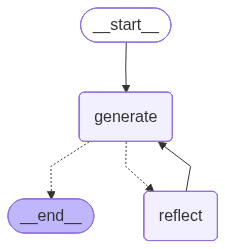

In [ ]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
graph

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="코딩에 대한 가사를 작성해주세요."
            )
        ],
    },
    config,
):
    print(event)
    print("---")

{'generate': {'messages': [AIMessage(content='새벽 창가에 물방울 자국이 맺히고, 커서가 깜빡인다\n화면은 은빛 달처럼 차분히 숨을 고르고\n한 줄의 코드가 이 방의 공기를 바꾼다\n타이핑 소리 밑에 커피의 쓴맛이 진동한다\n\n콘솔 로그가 빗물처럼 쏟아지고, 예외의 파도가 올라온다\n널 포인터의 그림자가 손끝에서 스르르 떠난다\n무한 루프의 기계적 숨, 나는 여전히 돌아가며 배우는 중\n작은 버그 하나가 어제의 확신을 흔들어 놓는다\n\n디버거를 켜고 스택 트래스를 따라간다\n함수의 골목에서 과거의 버그를 다시 바라본다\n주석은 길잡이, 비어 있는 변수 이름은 내일의 꿈\n리팩토링은 숨 고르기, 흐름은 점점 맑아진다\n\n마침표 대신 세미콜론이 일을 끝내고 화면이 떨림 없이 빛난다\n컴파일의 축제가 시작되고 서버의 심장이 뛰기 시작한다\n커밋 메시지는 오늘의 고백, 브랜치는 미래의 길\n배포가 끝나자 방 안의 정적도 조용히 물러선다\n\n코드가 내 하루의 일부가 되고, 반복은 습관이 된다\n에러는 배움의 씨앗, 성공은 또 다른 질문의 시작\n다음 버전의 꿈을 밀어 올리고, 새로운 함수에 답을 찾아간다\n나는 계속해서, 코드 위의 길을 걸어간다', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3836, 'prompt_tokens': 1478, 'total_tokens': 5314, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 3456, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-0

In [ ]:
state = graph.get_state(config)

In [ ]:
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

이별에 대한 가사를 작성해주세요.

================================== Ai Message ==================================

문을 열면 네 냄새가 남아 있어
함께 남긴 약속의 글자들은 벽에 흐려져 가네
창밖 빗소리는 네 이름을 속삭이며 흘려가고
여전히 네 기억을 쫓아 걷는 내 발걸음

네가 떠난 자리엔 차가운 바람이 스며들고
사진 속 널 떠올리면 미소는 오래도록 선명해
메시지는 시들고 화면은 어둠에 잠겨 있어
오늘의 나는 네가 남긴 빈 자리에서 숨 쉬고 있어

나는 남은 단어를 모아 작은 불을 지핀다
기억은 종이에 긁힌 흔들림, 아직 타지 않은 선들
네 이름을 불러보려 숨을 깊이 들이마셔 보았지만
대답은 바람에 흩날려 돌아오지 않네

그럼에도 나는 어둠을 가르고 길을 걷는다
새벽의 첫 빛이 상처를 닦아 주고
지나간 노래의 리듬이 아직 귀에 남아
천천히, 그러나 멈추지 않는 걸음을 택해

이별은 끝이 아니라 시작의 한 조각일 뿐
너 없는 날들에 나는 다시 나를 찾아 걷는다
언젠가 네가 남긴 빈자리에 햇살이 스며들기를
안녕, 고마웠어. 이 편린으로 나는 살아가리

================================ Human Message =================================

전반적 평가
- 분위기와 주제의 일관성은 좋습니다. 이별의 고통에서 벗어나려는 의지까지 점진적으로 그려져 있어 독자에게 공감과 위로를 줍니다.
- 강점으로는 감각적 이미지(냄새, 빗소리, 벽에 흐려지는 약속 글자), 의식의 흐름을 따라가는 서사구조, 그리고 마지막의 수용적 결말이 잘 연결됩니다.
- 다만 몇 군데는 진부한 표현이 보이고, 리듬과 구성이 다소 평평하게 느껴질 수 있습니다. 구체성과 리듬감을 강화하면 더 강렬하고 기억에 남는 가사가 될 가능성이 큽

## 2. Reflextion 구현
[“Reflexion: Language Agents with Verbal Reinforcement Learning”](https://arxiv.org/abs/2303.11366)은, 2023년 3월 20일 최초 제출, 2023년 10월 10일 v4로 개정된 논문입니다. 저자는 Noah Shinn 외 5명이고, 핵심 내용은 언어 에이전트가 스스로 언어적 피드백(반성문)을 생성·메모리에 저장해 다음 시도에 반영함으로써 성능을 높이는 프레임워크를 제안했다는 점입니다. HumanEval 등에서 유의미한 향상을 보고합니다.

<img src="https://blog.kakaocdn.net/dna/TE252/btsQwhkpIq8/AAAAAAAAAAAAAAAAAAAAAKpNciWbSIUMiGE5-K-UgaF4YTu3a1Z10Fx4OLCK2GRc/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=bEVF2KybKuElMkq83PL%2FKLUB6PI%3D">

- Actor (LM): 실제 행동(답안 작성, 코드 생성 등)을 내는 언어모델입니다.
- Evaluator (LM): Actor가 낸 결과를 내부적으로 평가합니다(정확성·형식·테스트 통과 여부 판단 등).
- Self-reflection (LM): 평가 결과를 바탕으로 “다음에는 이렇게 고치자” 같은 반성문(Reflective text)을 만들어 냅니다.
- Trajectory (short-term memory): 이번 시도에서의 행동/관찰 기록(a₀, o₀, …)을 담는 단기 메모리입니다.
- Experience (long-term memory): 누적된 반성문을 쌓아두는 장기 메모리(mem)입니다. 이후 시도에서 프롬프트에 이 기억을 넣어 같은 실수를 반복하지 않게 합니다.
- Environment: 외부에서 관찰/보상(예: 유닛 테스트의 통과/실패, 웹툴의 응답 등)을 제공합니다. 외부 피드백이 있으면 - Evaluator의 판단과 함께 사용됩니다.

<img src="https://blog.kakaocdn.net/dna/dxvilH/btsQzDeZ087/AAAAAAAAAAAAAAAAAAAAAJJ8QC-VUzoYLsotdKq1OrXdCNGqhzHG2zdCbJWUWL20/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=3bY%2FbXiSMYffNl7EjR8Qtto1mK8%3D" width=800>

In [ ]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-5-nano")

In [ ]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
!pip install langchain-tavily

In [ ]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=5)

### 1. 필요한 데이터 클래스 정의

- Reflection - 놓친것 / 불필요한 것

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field

class Reflection(BaseModel):
    missing: str = Field(description="누락되거나 부족한 부분에 대한 비평")
    superfluous: str = Field(description="불필요한 부분에 대한 비평")

- AnswerQuestion - 답변 / 답변에 대한 반성 / 개선하기 위한 검색 쿼리

In [ ]:
class AnswerQuestion(BaseModel):
    answer: str = Field(description="질문에 대한 10문장 이내의 자세한 답변")
    search_queries: list[str] = Field(
        description="현재 답변에 대한 비평을 해결하기 위한 추가 조사를 위한 1~3개의 웹 검색 쿼리"
    )
    reflection: Reflection = Field(description="답변에 대한 자기반성 내용")

- Responder - 구조화된 출력을 위한 답변기

In [ ]:
class Responder:
    def __init__(self, runnable):
        self.runnable = runnable # Chain

    def respond(self, state: dict):
        response = self.runnable.invoke(
            {"messages": state["messages"]}
        )
        return {"messages": response}

### 2. 초기 답변기 만들기 (Initial responder)

- 초기 답변을 위한 Chain 생성 -출력 스키마를 도구로 사용

In [ ]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """당신은 전문 연구자입니다.

            1. {first_instruction}
            2. <Reflect> 생성한 답변을 다시 되돌아보고 개선할 수 있도록 비판하세요.
            3. <Recommend search queries> 답변의 질을 높이기 위해 추가적으로 조사해야 할 정보에 대한 웹 검색 쿼리를 추천하세요.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<Reflect> 사용자 원래 질문과 지금까지의 행동을 되돌아보세요."
        ),
    ]
)

initial_answer_chain = actor_prompt_template.partial(
    first_instruction="질문에 대한 10문장 이내의 자세한 답변을 제공해주세요.", # 초기 답변
) | llm.bind_tools(tools=[AnswerQuestion], tool_choice="any")

- [구조화 출력을 위해 스키마를 도구로 사용하는 방법](https://python.langchain.com/docs/concepts/structured_outputs/#using-tool-calling)

In [ ]:
llm_with_tool = llm.bind_tools(tools=[AnswerQuestion], tool_choice="any")
response = llm_with_tool.invoke([HumanMessage(content="AI Agent가 무엇인가요?")])
print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_S9IyPfKrJpVlQnhDjsiuwcAn', 'function': {'arguments': '{"answer":"AI 에이전트는 특정 목표를 달성하기 위해 환경을 감지하고 판단한 뒤 행동을 선택하고 실행하는 소프트웨어 시스템이나 로봇을 말합니다. 일반적으로 입력(센서, 데이터)을 받아 상태를 이해하고, 목표를 달성하기 위한 계획을 세운 뒤, 적절한 행동(명령 실행, 데이터 처리, API 호출)을 수행합니다. 에이전트는 자율성, 학습 능력, 상호작용 정도에 따라 단순 반응형에서 고도 의사결정 시스템까지 다양합니다. 예를 들어 로봇 청소기는 방의 지도를 만들고 먼지 제거를 최적화하는 에이전트이고, 챗봇은 사용자의 의도에 맞춰 대답을 선택하는 대화 에이전트입니다. 또한 실행 환경이 바뀔 때도 적응하도록 설계될 수 있습니다. 유형으로는 심층 강화학습을 사용하는 학습 에이전트, 계획 기반 에이전트, 규칙 기반 에이전트 등이 있습니다. 핵심 구성은 감지(센서), 의사결정(정책/플래너), 행동(실행 모듈)로 요약할 수 있습니다.","search_queries":["AI 에이전트 정의 예시","에이전트와 프로그램의 차이","자율 에이전트 예시 로봇"],"reflection":{"missing":"실무 맥락의 예시와 안전/윤리 고려, 간단한 계층 아키텍처 다이어그램에 대한 언급이 보강되면 좋습니다.","superfluous":"현재 설명은 초보자 이해에 충분하지만 아주 깊은 이론적 수학이나 고급 구현 세부는 필요 없거나 보강될 수 있습니다."}}', 'name': 'AnswerQuestion'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 2068, 'prompt_tokens': 208, 'total_tokens': 2276, 'completio

In [ ]:
response.tool_calls[0]['args']

{'answer': 'AI 에이전트는 특정 목표를 달성하기 위해 환경을 감지하고 판단한 뒤 행동을 선택하고 실행하는 소프트웨어 시스템이나 로봇을 말합니다. 일반적으로 입력(센서, 데이터)을 받아 상태를 이해하고, 목표를 달성하기 위한 계획을 세운 뒤, 적절한 행동(명령 실행, 데이터 처리, API 호출)을 수행합니다. 에이전트는 자율성, 학습 능력, 상호작용 정도에 따라 단순 반응형에서 고도 의사결정 시스템까지 다양합니다. 예를 들어 로봇 청소기는 방의 지도를 만들고 먼지 제거를 최적화하는 에이전트이고, 챗봇은 사용자의 의도에 맞춰 대답을 선택하는 대화 에이전트입니다. 또한 실행 환경이 바뀔 때도 적응하도록 설계될 수 있습니다. 유형으로는 심층 강화학습을 사용하는 학습 에이전트, 계획 기반 에이전트, 규칙 기반 에이전트 등이 있습니다. 핵심 구성은 감지(센서), 의사결정(정책/플래너), 행동(실행 모듈)로 요약할 수 있습니다.',
 'search_queries': ['AI 에이전트 정의 예시', '에이전트와 프로그램의 차이', '자율 에이전트 예시 로봇'],
 'reflection': {'missing': '실무 맥락의 예시와 안전/윤리 고려, 간단한 계층 아키텍처 다이어그램에 대한 언급이 보강되면 좋습니다.',
  'superfluous': '현재 설명은 초보자 이해에 충분하지만 아주 깊은 이론적 수학이나 고급 구현 세부는 필요 없거나 보강될 수 있습니다.'}}

In [ ]:
first_responder = Responder(runnable=initial_answer_chain)

In [ ]:
example_question = "AI Agent가 무엇인가요?"
initial = first_responder.respond(
    {"messages": [HumanMessage(content=example_question)]}
)

In [ ]:
initial

{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qRHHAcsryXtNTBoNIfvsd8lX', 'function': {'arguments': '{"answer":"AI Agent(인공지능 에이전트)는 특정 목표를 달성하기 위해 독립적으로 판단하고 행동하는 소프트웨어 구성요소 또는 시스템을 말합니다. 보통 입력을 받아 환경의 상태를 이해하고, 그 상태에 기반해 의사결정을 내리며, 특정 행동을 실행합니다. 에이전트는 주어진 목표와 약속된 제약 내에서 작동하며, 일부는 학습 capacity가 있어 경험으로 정책을 개선합니다. 예를 들어 스마트홈의 온도 조정 시스템, 자동화된 챗봇, 자율주행차의 의사결정 모듈 등이 에이전트의 예시일 수 있습니다. 오늘날의 AI 에이전트는 크게 반응형(현 상태만 보는)부터 계획형(장기 목표를 세워 단계적으로 실행)까지 다양합니다. 주된 차이는 목표 정의 방식, 환경에 대한 관찰 능력, 결정을 내리는 알고리즘의 복잡도, 그리고 피드백으로 정책을 업데이트하는 여부입니다. 간단히 말해 에이전트는 \'무엇을 원하는가\'를 정의하고, \'그 결과를 얻기 위해 무엇을 할 것인가\'를 스스로 결정합니다. 사용 사례에 따라 인간과의 협업형 에이전트, 완전 자동화 에이전트, 또는 혼합형 시스템으로 분류됩니다. 이 개념은 인공지능의 더 큰 분야인 에이전트 기반 시스템, 강화학습, 자동화와 밀접하게 연결됩니다. 필요하시면 구체적인 사례를 더 설명하겠습니다.","search_queries":["AI 에이전트 정의 구성요소 관찰-판단-행동 루프","에이전트 기반 시스템과 강화학습의 차이 비교","실무에서의 AI 에이전트 사례와 적용 분야"],"reflection":{"missing":"좀 더 구체적으로 관찰-판단-행동 루프, 상태 관리, 자율성 수준, 학습 여부에 대한 분류를 보강하면 좋습니다.","superfluous":"기술적 세부사항(모델 아키텍처, 파라

- tool 호출 결과 확인 (AnswerQuestion 에 맞춰 출력 생성)

In [ ]:
initial["messages"].tool_calls[0]["args"]

{'answer': "AI Agent(인공지능 에이전트)는 특정 목표를 달성하기 위해 독립적으로 판단하고 행동하는 소프트웨어 구성요소 또는 시스템을 말합니다. 보통 입력을 받아 환경의 상태를 이해하고, 그 상태에 기반해 의사결정을 내리며, 특정 행동을 실행합니다. 에이전트는 주어진 목표와 약속된 제약 내에서 작동하며, 일부는 학습 capacity가 있어 경험으로 정책을 개선합니다. 예를 들어 스마트홈의 온도 조정 시스템, 자동화된 챗봇, 자율주행차의 의사결정 모듈 등이 에이전트의 예시일 수 있습니다. 오늘날의 AI 에이전트는 크게 반응형(현 상태만 보는)부터 계획형(장기 목표를 세워 단계적으로 실행)까지 다양합니다. 주된 차이는 목표 정의 방식, 환경에 대한 관찰 능력, 결정을 내리는 알고리즘의 복잡도, 그리고 피드백으로 정책을 업데이트하는 여부입니다. 간단히 말해 에이전트는 '무엇을 원하는가'를 정의하고, '그 결과를 얻기 위해 무엇을 할 것인가'를 스스로 결정합니다. 사용 사례에 따라 인간과의 협업형 에이전트, 완전 자동화 에이전트, 또는 혼합형 시스템으로 분류됩니다. 이 개념은 인공지능의 더 큰 분야인 에이전트 기반 시스템, 강화학습, 자동화와 밀접하게 연결됩니다. 필요하시면 구체적인 사례를 더 설명하겠습니다.",
 'search_queries': ['AI 에이전트 정의 구성요소 관찰-판단-행동 루프',
  '에이전트 기반 시스템과 강화학습의 차이 비교',
  '실무에서의 AI 에이전트 사례와 적용 분야'],
 'reflection': {'missing': '좀 더 구체적으로 관찰-판단-행동 루프, 상태 관리, 자율성 수준, 학습 여부에 대한 분류를 보강하면 좋습니다.',
  'superfluous': '기술적 세부사항(모델 아키텍처, 파라미터 수)이나 윤리적 이슈 같은 주제는 이 기본 정의에서 제외하는 편이 좋습니다.'}}

### 3. 수정 단계(Revision)

In [ ]:
class ReviseAnswer(AnswerQuestion):
    # 답변 > 반성 > 근거 인용 > 검색 제안
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="업데이트된 답변에 사용된 인용 출처"
    )

In [ ]:
revise_instructions = """이전 답변을 새로운 정보를 바탕으로 수정하세요.
- 이전 비평 내용을 활용해 중요한 정보를 추가해야 합니다.
  - 수정된 답변에는 반드시 숫자로 된 인용 표시를 포함하여 검증 가능하도록 해야 합니다.
  - 답변 하단에 "참고문헌" 섹션을 추가하세요 (이 부분은 단어 수 제한에 포함되지 않습니다). 형식은 다음과 같습니다:
    - [1] https://example.com
    - [2] https://example.com

- 이전 비평 내용을 바탕으로 불필요한 정보를 제거하고, 최종 답변은 반드시 200자를 넘지 않도록 하세요.
"""


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice="any")


revisor = Responder(runnable=revision_chain)

- 초기답변에서 생성한 웹검색 쿼리를 Tool 실행한 결과를 함께 입력

In [ ]:
import json

revised = revisor.respond(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial['messages'].additional_kwargs['tool_calls'][0]['id'],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"]['search_queries'][0]
                        }
                    )
                ),
            ),
        ]
    }
)

<img src="https://blog.kakaocdn.net/dna/bk9H1l/btsQzJzpfvC/AAAAAAAAAAAAAAAAAAAAACJKpwEAA8XFASLM3eNktiwFHoYdWKTyU6DOvuweWB3S/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=9c%2BBXwbClSPdn8Pra4HPaL4KLqw%3D" width=800>

In [ ]:
revised["messages"]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IDorpVb8I5zzIZbZ8XKTvIW7', 'function': {'arguments': '{"answer":"AI 에이전트는 목표 달성을 위해 관찰-판단-행동 루프를 독립적으로 수행하는 소프트웨어 구성요소입니다. 입력 정보를 해석하고 의사결정을 내려 행동을 실행합니다. 자율성 수준과 학습 여부에 따라 반응형에서 계획형까지 다양합니다. [1] [2]","search_queries":["AI 에이전트 정의 구성요소 관찰-판단-행동 루프","에이전트 기반 시스템과 강화학습의 차이 비교","실무에서의 AI 에이전트 사례와 적용 분야"],"reflection":{"missing":"좀 더 구체적으로 관찰-판단-행동 루프, 상태 관리, 자율성 수준, 학습 여부에 대한 분류를 보강하면 좋습니다.","superfluous":"기술적 세부사항(모델 아키텍처, 파라미터 수)이나 윤리적 이슈 같은 주제는 이 기본 정의에서 제외하는 편이 좋습니다."},"references":["https://cloud.google.com/discover/what-are-ai-agents?hl=ko","https://www.automationanywhere.com/kr/company/blog/automation-ai/exploring-ai-agents-types-capabilities-and-real-world-applications"]}', 'name': 'ReviseAnswer'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3043, 'prompt_tokens': 3930, 'total_tokens': 6973, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_t

In [ ]:
revised["messages"].tool_calls

[{'name': 'ReviseAnswer',
  'args': {'answer': 'AI 에이전트는 목표 달성을 위해 관찰-판단-행동 루프를 독립적으로 수행하는 소프트웨어 구성요소입니다. 입력 정보를 해석하고 의사결정을 내려 행동을 실행합니다. 자율성 수준과 학습 여부에 따라 반응형에서 계획형까지 다양합니다. [1] [2]',
   'search_queries': ['AI 에이전트 정의 구성요소 관찰-판단-행동 루프',
    '에이전트 기반 시스템과 강화학습의 차이 비교',
    '실무에서의 AI 에이전트 사례와 적용 분야'],
   'reflection': {'missing': '좀 더 구체적으로 관찰-판단-행동 루프, 상태 관리, 자율성 수준, 학습 여부에 대한 분류를 보강하면 좋습니다.',
    'superfluous': '기술적 세부사항(모델 아키텍처, 파라미터 수)이나 윤리적 이슈 같은 주제는 이 기본 정의에서 제외하는 편이 좋습니다.'},
   'references': ['https://cloud.google.com/discover/what-are-ai-agents?hl=ko',
    'https://www.automationanywhere.com/kr/company/blog/automation-ai/exploring-ai-agents-types-capabilities-and-real-world-applications']},
  'id': 'call_IDorpVb8I5zzIZbZ8XKTvIW7',
  'type': 'tool_call'}]

### 4. 웹검색을 위한 툴 노드 생성

In [ ]:
tavily_tool.batch(
    [
        {"query": initial["messages"].tool_calls[0]["args"]['search_queries'][0]}
    ]
)

[{'query': 'AI 에이전트 정의 구성요소 관찰-판단-행동 루프',
  'follow_up_questions': None,
  'answer': None,
  'images': [],
  'results': [{'url': 'https://aiheroes.ai/community/300',
    'title': 'AI 에이전트는 어떻게 작동할까? 에이전트 워크플로우 완벽 이해하기',
    'content': "생각과 행동(액션)에 이어서, 에이전트 워크플로우의 마지막 핵심 구성 요소는 '관찰'입니다. 관찰은 에이전트가 세계를 이해하고, 자신의 행동 결과",
    'score': 0.98593,
    'raw_content': None},
   {'url': 'https://www.automationanywhere.com/kr/company/blog/automation-ai/exploring-ai-agents-types-capabilities-and-real-world-applications',
    'title': 'AI 에이전트 알아보기: 유형, 기능 및 활용 분야 - Automation Anywhere',
    'content': 'AI 에이전트는 환경을 인식하고, 수집된 정보를 바탕으로 추론하며, 미리 정의된 목표를 달성하기 위해 적절한 행동을 취하는 정교한 소프트웨어 프로그램',
    'score': 0.98302,
    'raw_content': None},
   {'url': 'https://tech.ktcloud.com/entry/2025-03-ktcloud-ai-agent-%EC%97%90%EC%9D%B4%EC%A0%84%ED%8A%B8-%EC%9C%A0%ED%98%95%EA%B3%BC%ED%8A%B9%EC%84%B1',
    'title': '[Tech Series] kt cloud AI 에이전트 #2 : 에이전트의 유형과 특성',
    'content': '![[Tech Series] kt cloud AI 에이전트 #2

In [ ]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):   # 키워드 arguments
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

### 5. 그래프 생성하기

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
MAX_ITERATIONS = 5
graph_builder = StateGraph(State)
graph_builder.add_node("draft", first_responder.respond)

graph_builder.add_node("execute_tools", tool_node) # 웹 검색 진행
graph_builder.add_node("revise", revisor.respond)

graph_builder.add_edge("draft", "execute_tools")
graph_builder.add_edge("execute_tools", "revise")

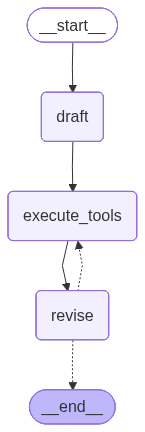

In [ ]:
def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list):
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


graph_builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
graph_builder.add_edge(START, "draft")
graph = graph_builder.compile()
graph

In [ ]:
events = graph.stream(
    {"messages": [HumanMessage(content="AI Agent가 무엇인가요?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

AI Agent가 무엇인가요?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_jazmMD4wLyvV2mhJlTPwOFaT)
 Call ID: call_jazmMD4wLyvV2mhJlTPwOFaT
  Args:
    answer: AI 에이전트(Agent)란 주어진 목표를 달성하기 위해 환경을 인지하고 행동하는 자율적 시스템입니다. 일반적으로 에이전트는 환경을 감지하는 센서와 행동을 실행하는 액추에이터를 통해 상호작용합니다. 에이전트는 관찰(퍼셙션)을 바탕으로 의사결정을 하고, 경우에 따라 계획하고 학습하며 행동합니다. 합리적 에이전트는 주어진 지식과 기대되는 결과를 바탕으로 성능을 최대화하는 행동을 선택합니다. 에이전트의 유형으로는 반응적(즉시 자극에 반응), 계획적(미래를 고려한 계획), 학습 에이전트, 목표 기반/효용 기반 에이전트 등이 있습니다. 대화형 에이전트(챗봇 등)도 흔한 예로, 사용자와 상호작용하는 소프트웨어 에이전트입니다. 에이전트와 일반 프로그램의 차이는 목표 지향성, 상태 유지, 학습 및 적응 능력, 그리고 다른 에이전트와의 상호작용 여부에 있습니다. 설계 시 성능 척도(성과함수), 환경 모델, 가능한 행동 공간, 학습 방법을 정의해야 합니다. 한계로는 불완전한 정보, 확정불가능한 환경, 안전성과 윤리적 고려가 필요합니다.
    search_queries: ['AI 에이전트 정의 합리적 에이전트', '에이전트-환경 상호작용 퍼셉션-액션 루프', '학습 에이전트 예시 그리고 차이점']
    reflection: {'missing': '좀 더 포멀한 정의를 수식적으로 보일 수 있다면 좋고, 예시를 도메인별로 구체

## Plan & Execute

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [ ]:
!pip install langchain_community

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
search_tool = TavilySearchResults(max_results=3)
tools = [search_tool]

/tmp/ipython-input-3618365131.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=3)


In [ ]:
!pip install langchain_openai

In [ ]:
!pip install langgraph

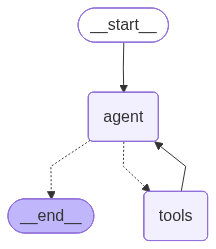

In [ ]:
# ReAct 패턴
# 추론 -> 행동 -> 관찰 -> 답변, 자동으로 생성
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-5-nano")
prompt = "You are a helpful assistant."
plan_executor = create_react_agent(llm, tools, prompt=prompt)
plan_executor

In [ ]:
plan_executor.invoke({'messages':[('user','2025년 한국의 최저 시급은 얼마입니까?')]})

{'messages': [HumanMessage(content='2025년 한국의 최저 시급은 얼마입니까?', additional_kwargs={}, response_metadata={}, id='5246eeea-30d5-45e2-a0eb-3b41f09ff31c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vbkT3Uqz30VEyNN9hMiisgcT', 'function': {'arguments': '{"query":"2025년 한국 최저 시급"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 418, 'prompt_tokens': 183, 'total_tokens': 601, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CFt3lmsjzUlOyhuF8XKrWERi71g8L', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--147f3583-f12b-4211-9a88-4476fcc44fbe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'qu

In [ ]:
from pydantic import BaseModel, Field
from typing import List
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage

In [ ]:
class Plan(BaseModel):
    """Plan to follow in future"""
    steps: List[str] = Field(
        # 단계별 진행 예정
        description="different steps to follow, should be in sorted order"
    )

In [ ]:
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
            This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
            The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)

In [ ]:
plan_result = planner.invoke(
    {
        "messages": [HumanMessage(
            content="2025년 한국에서 개봉한 영화 중 가장 흥행한 영화는 무엇인가요?",
        )]
    }
)

In [ ]:
plan_result.steps

['1. 2025년에 한국에서 개봉한 모든 영화의 목록을 확인한다.',
 '2. 각 영화의 국내 흥행 수익을 KOFIC의 KOBIS 데이터 등 신뢰 가능한 출처에서 수집한다.',
 '3. 수익 기준으로 내림차순 정렬하여 1위 후보를 선정한다.',
 '4. 최종적으로 1위의 영화 제목을 결과로 제시한다.']

In [ ]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

    Your objective was this:
    {input}

    Your original plan was this:
    {plan}

    You have currently done the follow steps:
    {past_steps}

    Update your plan accordingly.
    If no more steps are needed and you can return to the user, then respond with that.
    Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done.
    Do not return previously done steps as part of the plan."""
)

In [ ]:
from typing import Union

class Response(BaseModel):
    """Response to user."""
    response: str

class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [ ]:
replanner = replanner_prompt | llm.with_structured_output(Act)

In [ ]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [ ]:
# 계획 생성
def plan_step(state: PlanExecute):  # 계획을 생성하는 노드
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

In [ ]:
# 계획 실행
def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
    {plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = plan_executor.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)], # 실행 완료한 계획과 결과 저장
    }

In [ ]:
# 계획 수정
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    if isinstance(output.action, Response): # 답변이 바로 가능한 상태
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

In [ ]:
from langgraph.graph import END

def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

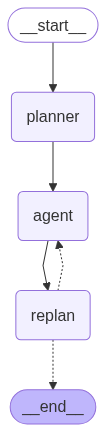

In [ ]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(PlanExecute)
graph_builder.add_node("planner", plan_step)
graph_builder.add_node("agent", execute_step)
graph_builder.add_node("replan", replan_step)
graph_builder.add_edge(START, "planner")
graph_builder.add_edge("planner", "agent")
graph_builder.add_edge("agent", "replan")
graph_builder.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)

graph = graph_builder.compile()
graph

In [ ]:
config = {'recursion_limit':50}
inputs = {'input' :'2024년 노벨 문학상 수상자의 출신국가는 어디인가요?'}

for event in graph.stream(inputs, config=config, stream_mode='values'):
    for k,v in event.items():
        print(k,v)
    print('*'*50)

input 2024년 노벨 문학상 수상자의 출신국가는 어디인가요?
past_steps []
**************************************************
input 2024년 노벨 문학상 수상자의 출신국가는 어디인가요?
plan ['1) 공식 노벨상 웹사이트에서 2024년 노벨문학상 수상자를 확인한다.', '2) 수상자의 프로필(또는 신뢰 가능한 출처)에서 출생국가를 확인한다.', '3) 확인된 출생국가를 한국어 표현으로 기록한다.', '4) 한국어로 최종 답을 작성한다(예: 수상자의 출생국가는 ○○입니다).', '5) 필요 시 출처를 함께 제시하여 확인 가능하도록 한다.']
past_steps []
**************************************************
input 2024년 노벨 문학상 수상자의 출신국가는 어디인가요?
plan ['1) 공식 노벨상 웹사이트에서 2024년 노벨문학상 수상자를 확인한다.', '2) 수상자의 프로필(또는 신뢰 가능한 출처)에서 출생국가를 확인한다.', '3) 확인된 출생국가를 한국어 표현으로 기록한다.', '4) 한국어로 최종 답을 작성한다(예: 수상자의 출생국가는 ○○입니다).', '5) 필요 시 출처를 함께 제시하여 확인 가능하도록 한다.']
past_steps [('1) 공식 노벨상 웹사이트에서 2024년 노벨문학상 수상자를 확인한다.', '확인 결과:\n- 2024년 노벨문학상 수상자는 Han Kang(한강)입니다.\n- 공식 노벨상 웹사이트에 수상자 정보가 등재되어 있습니다: https://www.nobelprize.org/prizes/literature/2024/summary/')]
**************************************************
input 2024년 노벨 문학상 수상자의 출신국가는 어디인가요?
plan ['2) 수상자의 공식 프로필 또는 신뢰 가능한 출처에서 출생지(국가)를 확인한다.', '3) 확인된 출생국가를

## 4. 코드 수정을 반복하는 데이터 전처리 Agent

### 클로드

클로드(Claude)는 앤트로픽(Anthropic)에서 개발한 대규모 언어 모델(LLM) 기반의 인공지능 챗봇으로, 사람과의 대화, 글쓰기, 요약, 코드 작성 등 다양한 작업을 수행할 수 있는 생성형 AI입니다. 이름은 인공지능의 선구자 클로드 섀넌(Claude Shannon)에서 따왔으며, “헌宪법 기반 AI(constitutional AI)” 접근법을 적용해 안전성과 투명성을 강화한 것이 특징입니다. 즉, 인간의 직접적인 지시보다는 미리 정해둔 원칙과 가이드라인을 통해 스스로 출력을 조율하도록 설계되었기 때문에, 사용자가 안심하고 활용할 수 있는 대화형 AI라는 점에서 주목받고 있습니다.

In [19]:
import getpass
import os
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY: ··········


In [2]:
from langchain_core.tools import tool
import pandas as pd

In [3]:
@tool
def describe_data(csv: str) -> str:
    """Describe the date column in the dataframe.
    Args:
        csv: csv data path string
    """
    df = pd.read_csv(csv)
    describe_str = f"""Data: {csv}""" + df.describe(include='all').to_string()
    return describe_str

In [4]:
tools=[describe_data]

In [6]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.75
    Uninstalling langchain-core-0.3.75:
      Successfully uninstalled langchain-core-0.3.75


In [7]:
!pip install langchain_anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 kB 7.0 MB/s eta 0:00:00


In [8]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
llm_gpt = ChatOpenAI(model="gpt-5-nano")
llm_with_tools = llm_gpt.bind_tools(tools, tool_choice="any")

In [9]:
response = llm_with_tools.invoke(
    "https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv 이 데이터의 전처리를 해주세요."
)

In [10]:
response.tool_calls[0]['args']

{'csv': 'https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv'}

In [11]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions."""
    # 코드에 대한 접근방식
    prefix: str = Field(description="Description of the problem and approach")
    # 코드의 import 영역
    imports: str = Field(description="Code block import statements")
    # 코드 자체에 대한
    code: str = Field(description="Code block not including import statements")

In [12]:
from langchain_core.prompts import ChatPromptTemplate

GENERATE_CODE_TEMPLATE = """
Given the following pandas `describe()` output of a dataset,
write a **directly executable Python code** to:
1. handle missing values,
2. convert categorical columns,
3. ...any additional preprocessing needed,
4. prepare the dataset for machine learning.
Here is the describe result of the dataset:
\n ------- \n  {context} \n ------- \n
Do not wrap the code in a function and the response in any backticks or anything else. The code should be written as a flat script, so that it can be run immediately and any errors will be visible during execution.
Ensure any code you provide can be executed \n
with all required imports and variables defined. Structure your answer with a description of the code solution. \n
Then list the imports. And finally list the functioning code block.
"""

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", GENERATE_CODE_TEMPLATE),
    ]
)

In [14]:
from langchain_anthropic import ChatAnthropic

llm_claude= ChatAnthropic(model="claude-sonnet-4-20250514")

In [15]:
tool_result = describe_data.invoke(response.tool_calls[0]['args'])
print(tool_result)

Data: https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv       Number of times pregnant  Plasma glucose concentration a 2 hours in an oral glucose tolerance test  Diastolic blood pressure (mm Hg)  Triceps skin fold thickness (mm)  2-Hour serum insulin (mu U/ml)  Body mass index (weight in kg/(height in m)^2)  Diabetes pedigree function  Age (years)  Class variable
count                768.000000                                                                768.000000                        768.000000                        768.000000                      768.000000                                      768.000000                  768.000000   768.000000      768.000000
mean                   3.845052                                                                120.894531                         69.105469                         20.536458                       79.799479                                       31.992578                    0.471876    33.240885

In [21]:
generated_code = llm_claude.invoke(
    code_gen_prompt.format_messages(context=tool_result)
)
print("generated_code", generated_code)
# 클라드 결제 안되서 키 에러남

TypeError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"

In [22]:
code_structurer = llm_gpt.with_structured_output(code)
code_solution = code_structurer.invoke(generated_code.content)
print("code_solution", code_solution)

NameError: name 'generated_code' is not defined

In [23]:
print(code_solution.imports)

NameError: name 'code_solution' is not defined

In [24]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.2 MB/s eta 0:00:00


In [25]:
from langgraph.graph import StateGraph, MessagesState

class State(MessagesState): # messages
    """
    Represents the state of our graph.
    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        context: Data summary
        generation : Code solution
        iterations : Number of tries
    """
    error: str # yes or no
    context: str
    generation: str
    iterations: int
graph_builder = StateGraph(State)

In [26]:
llm_with_tools = llm_gpt.bind_tools(tools=[describe_data])  # llm이 알아서 하도록

In [27]:
def chatbot(state: State):
    print("##### HI ! #####")
    response = llm_with_tools.invoke(state["messages"])
    print("첫번째 LLM 호출 결과 : ", response)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

In [28]:
def add_context(state: State):
    print("##### ADD CONTEXT #####")
    if messages := state.get("messages", []):
        message = messages[-1] # 마지막 message 꺼내서 저장
    else:
        raise ValueError("No message found in input")
    for tool_call in message.tool_calls:
        for tool in tools:
            if tool.name == tool_call['name']:
                describe_str = tool.invoke(tool_call['args'])

    # Get context from describe_data tool
    print("데이터 통계 (context) : ", describe_str[:100])
    return {"context": describe_str}

graph_builder.add_node("add_context", add_context)

In [29]:
from langgraph.graph import END

def guardrail_route(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "add_context"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    guardrail_route,
    {"add_context": "add_context", END: END},
)

In [30]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions."""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

In [31]:
from langchain_core.prompts import ChatPromptTemplate

GENERATE_CODE_TEMPLATE = """
Given the following pandas `describe()` output of a dataset,
write a **directly executable Python code** to:
1. handle missing values,
2. convert categorical columns,
3. ...any additional preprocessing needed,
4. prepare the dataset for machine learning.
Here is the describe result of the dataset:
\n ------- \n  {context} \n ------- \n
Do not wrap the code in a function and the response in any backticks or anything else. The code should be written as a flat script, so that it can be run immediately and any errors will be visible during execution.
Ensure any code you provide can be executed \n
with all required imports and variables defined. Structure your answer with a description of the code solution. \n
Then list the imports. And finally list the functioning code block.
"""

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", GENERATE_CODE_TEMPLATE),
    ]
)

In [32]:
def generate(state: State):
    print("##### GENERATING CODE SOLUTION #####")
    context = state["context"]
    generated_code = llm_claude.invoke(
        code_gen_prompt.format_messages(context=context)
    )
    code_structurer = llm_gpt.with_structured_output(code)
    code_solution = code_structurer.invoke(generated_code.content)
    messages = [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]
    return {"generation": code_solution, "messages": messages}
graph_builder.add_node("generate", generate)

In [33]:
def code_check(state: State):
    print("##### CHECKING CODE #####")
    code_solution = state["generation"]
    imports = code_solution.imports
    code = code_solution.code
    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        print("에러 메시지 : ", error_message)
        return {
            "generation": code_solution,
            "messages": error_message,
            "error": "yes",
        }
    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        print("에러 메시지 : ", error_message)
        return {
            "generation": code_solution,
            "messages": error_message,
            "error": "yes",
        }
    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "error": "no",
    }
graph_builder.add_node("code_check", code_check)

In [34]:
from langchain_core.prompts import ChatPromptTemplate

reflect_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are given an error message that occurred while running a Python script, along with the original code that produced the error.
            Provide a corrected version of the original code that resolves the issue.
            Ensure the code runs without errors and maintains the intended functionality."""
        ),
        (
            "user",
            """
            --- ERROR MESSAGE ---
            {error}
            --- ORIGINAL CODE ---
            {code_solution}
            ----------------------
            Ensure any code you provide can be executed \n
            with all required imports and variables defined. Structure your answer with a description of the code solution. \n
            Then list the imports. And finally list the functioning code block.""",
        )
    ]
)

In [35]:
def reflect(state: State):
    print("---REFLECTING CODE SOLUTION---")
    error = state["messages"][-1].content
    code_solution = state["generation"]
    code_solution = f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}"
    corrected_code = llm_claude.invoke(reflect_prompt.format_messages(error=error, code_solution=code_solution))
    code_structurer = llm_gpt.with_structured_output(code)
    reflections = code_structurer.invoke(corrected_code.content)
    print("수정된 코드 : ", reflections)
    messages = [
        (
            "assistant",
            f"{reflections.prefix} \n Imports: {reflections.imports} \n Code: {reflections.code}",
        )
    ]
    return {"generation": reflections, "messages": messages, "iterations": state["iterations"] + 1}
graph_builder.add_node("reflect", reflect)


In [36]:
max_iterations=5

In [37]:
def decide_to_finish(state: State):
    error = state["error"]
    iterations = state["iterations"]
    if error == "no" or iterations == max_iterations: # 에러가 없거나 max_iterations에 도달하면 종료
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "reflect"

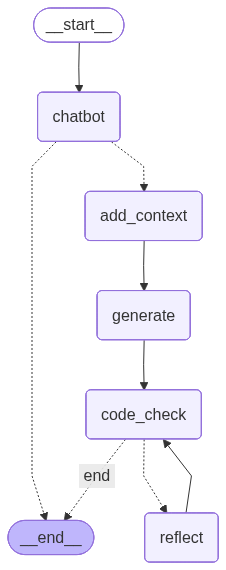

In [38]:
from langgraph.graph import START, END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("add_context", "generate")
graph_builder.add_edge("generate", "code_check")
graph_builder.add_conditional_edges(
    "code_check",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect"
    },
)
graph_builder.add_edge("reflect", "code_check")
graph = graph_builder.compile()
graph